### Loads basic python packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

### Loads the data

In [2]:
df_training = pd.read_csv("../train.csv")
df_test     = pd.read_csv("../test.csv")

df_training.drop('City', axis = 1, inplace=True)
df_test.drop('City', axis = 1, inplace=True)
display(df_training.head())
display(df_test.head())

,Customer Segment,ZIP,Store Number,Avg Num Products Purchased,# Years as Customer,Avg Sale Amount
0,Store Mailing List,80224,100,1,6,227.90
1,Store Mailing List,80111,105,1,6,55.00
2,Store Mailing List,80122,101,1,3,212.57
3,Store Mailing List,80239,105,1,6,195.31
4,Store Mailing List,80206,100,1,2,110.55


,Customer Segment,ZIP,Store Number,Avg Num Products Purchased,# Years as Customer
0,Loyalty Club Only,80015,105,3,0.2
1,Loyalty Club and Credit Card,80236,101,6,0.6
2,Loyalty Club Only,80110,101,7,0.9
3,Loyalty Club Only,80205,103,2,0.6
4,Loyalty Club Only,80015,104,4,0.5


array([[<matplotlib.axes.AxesSubplot object at 0x11017ab10>,
        <matplotlib.axes.AxesSubplot object at 0x110df0b10>]], dtype=object)

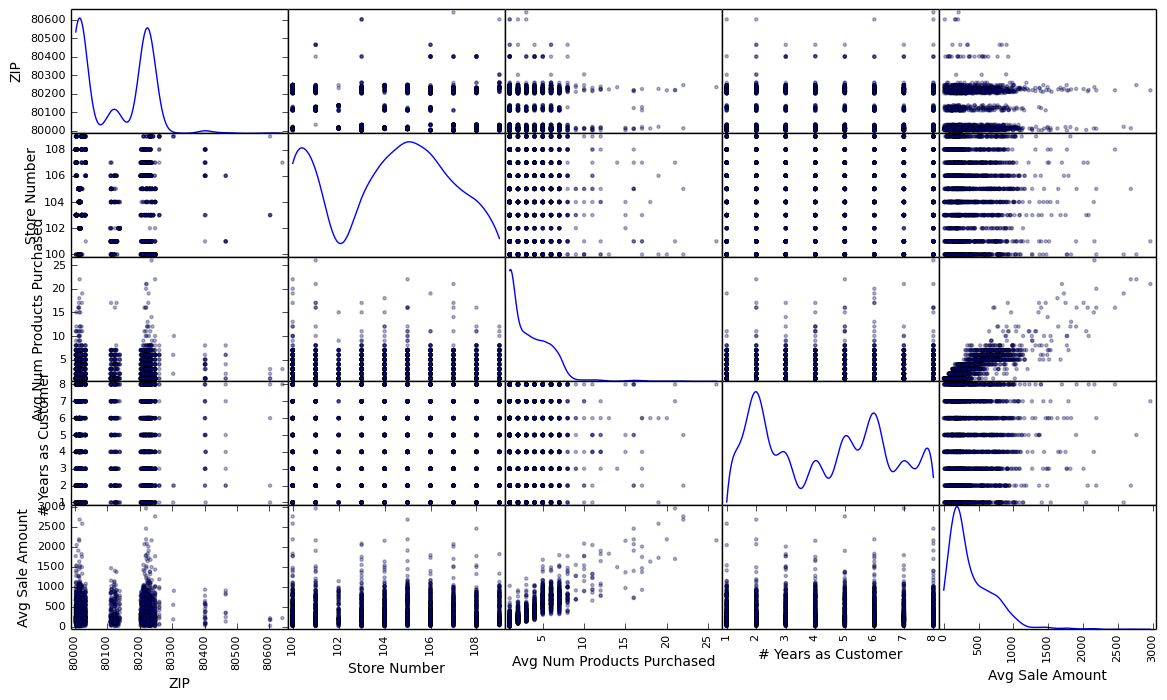

In [3]:
pd.scatter_matrix(df_training, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


,ZIP,Store Number,Avg Num Products Purchased,# Years as Customer,Avg Sale Amount
ZIP,1.000000,0.148906,0.001790,0.001643,0.007973
Store Number,0.148906,1.000000,0.011525,0.009573,0.007946
Avg Num Products Purchased,0.001790,0.011525,1.000000,0.043346,0.855754
# Years as Customer,0.001643,0.009573,0.043346,1.000000,0.029782
Avg Sale Amount,0.007973,0.007946,0.855754,0.029782,1.000000


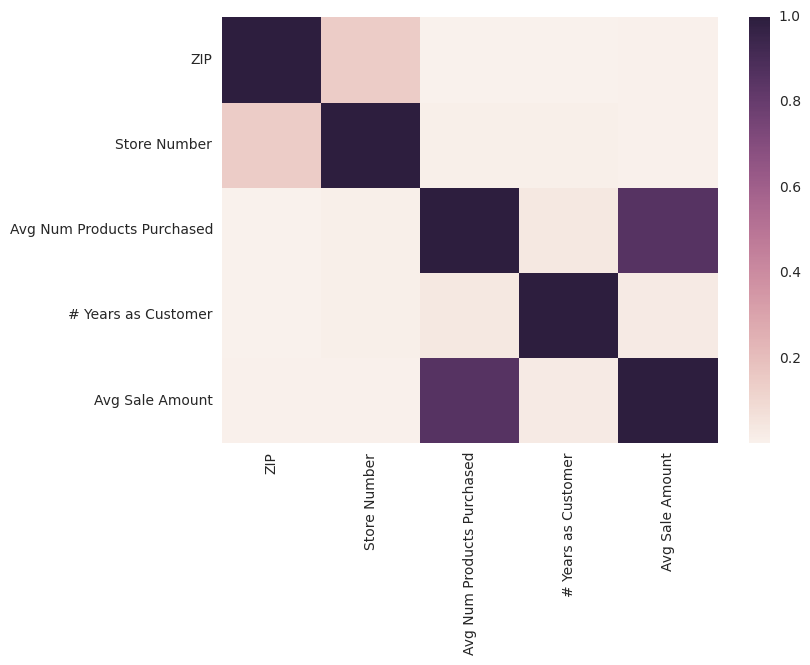

In [4]:
#### PLOTS THIS AS A HEATMAP
import seaborn as sns
df_correlation = df_training.corr().abs()
display(df_correlation)
sns.heatmap(df_correlation,
    xticklabels=df_correlation.columns.values,
    yticklabels=df_correlation.columns.values)

### Creates dummies for categorical data

In [5]:
### Convert all categorical data into dummies
toRemove             = []
dummiesNamesTraining = []
dummiesNamesTest     = []
for attribute in df_test.columns.values:
    if df_test[attribute].dtype == object:
        dummies_training = pd.get_dummies(df_training[attribute], prefix=[attribute])
        dummies_test     = pd.get_dummies(df_test[attribute], prefix=[attribute])
        for dummyName in dummies_training.columns.values:
            dummiesNamesTraining.append(dummyName)
        for dummyName in dummies_test.columns.values:
            dummiesNamesTest.append(dummyName)            
        if dummies_training.shape[1] > 2:
            df_training      = pd.concat([df_training, dummies_training], axis = 1)
            df_test          = pd.concat([df_test, dummies_test], axis = 1)
        else:
            df_training      = pd.concat([df_training, dummies_training[dummies_training.columns.values[0]]], axis = 1)
            df_test          = pd.concat([df_test, dummies_test[dummies_test.columns.values[0]]], axis = 1)
        toRemove.append(attribute)

        
#computes the dummies that are in both training and test sets
intersectionDummies = list(set(dummiesNamesTraining) & set(dummiesNamesTest))
# print "intersection = {}".format(intersectionDummies)
for att in dummiesNamesTraining:
    if att not in intersectionDummies:
        toRemove.append(att)
#         print "appended {}".format(att)


toRemove = list(set(toRemove))
for att in toRemove:
    df_training.drop(att, axis = 1, inplace = True)
    if att in df_test.columns.values:
        df_test.drop(att, axis = 1, inplace = True)

    
display(df_training.head())
# display(df_test.head())

,ZIP,Store Number,Avg Num Products Purchased,# Years as Customer,Avg Sale Amount,['Customer Segment']_Credit Card Only,['Customer Segment']_Loyalty Club Only,['Customer Segment']_Loyalty Club and Credit Card,['Customer Segment']_Store Mailing List
0,80224,100,1,6,227.90,0,0,0,1
1,80111,105,1,6,55.00,0,0,0,1
2,80122,101,1,3,212.57,0,0,0,1
3,80239,105,1,6,195.31,0,0,0,1
4,80206,100,1,2,110.55,0,0,0,1


### Training and test sets

In [6]:
### We don't have the labels for the test set, so I will have to work 
### using cross validation over the training data to be able to predict how good is my model
classLabel = 'Avg Sale Amount'
X_train = df_training.drop(classLabel, axis = 1)
Y_train = df_training[classLabel]
X_test = df_test

# display(X_train.head())
# display(Y_train.head())

### Computing the p-values for all variables

In [7]:
from sklearn.feature_selection import f_regression
_, pvalues = f_regression(X_train, Y_train)
index = 0
toRemove = []
for attribute in df_training.columns.values:
    if attribute != classLabel:
        pval = pvalues[index]
        print "{} has a p-value of {}".format(attribute, pval)        
        if pval > 0.05:
            toRemove.append(attribute)
        index = index + 1
        
print "Attributes with p-value > 0.05 = {}".format(toRemove)

for att in toRemove:
    X_train.drop(att, axis = 1, inplace=True)
    X_test.drop(att, axis = 1, inplace=True)

display(X_train.head())
display(X_test.head())

ZIP has a p-value of 0.697757997163
Store Number has a p-value of 0.698733999956
Avg Num Products Purchased has a p-value of 0.0
# Years as Customer has a p-value of 0.146794828448
['Customer Segment']_Credit Card Only has a p-value of 1.59755756527e-105
['Customer Segment']_Loyalty Club Only has a p-value of 0.779551878195
['Customer Segment']_Loyalty Club and Credit Card has a p-value of 3.76987503221e-224
['Customer Segment']_Store Mailing List has a p-value of 3.33692101866e-305
Attributes with p-value > 0.05 = ['ZIP', 'Store Number', '# Years as Customer', "['Customer Segment']_Loyalty Club Only"]


,Avg Num Products Purchased,['Customer Segment']_Credit Card Only,['Customer Segment']_Loyalty Club and Credit Card,['Customer Segment']_Store Mailing List
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1


,Avg Num Products Purchased,['Customer Segment']_Credit Card Only,['Customer Segment']_Loyalty Club and Credit Card,['Customer Segment']_Store Mailing List
0,3,0,0,0
1,6,0,1,0
2,7,0,0,0
3,2,0,0,0
4,4,0,0,0


### Splitting data into train and test

In [8]:
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
# paramsToTune = {}#'copy_X' : [True],
#                 'fit_intercept' : [True, False]}
# linreg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
# grid = GridSearchCV(linreg, paramsToTune, n_jobs=8, cv=10) # runs 10-fold cross-validation!
# grid.fit(X_train, Y_train)
# bestParams = grid.best_params_
# bestResults = grid.best_score_
# print "Results for the best parameters (R^2)= \n {}".format(bestResults)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

linreg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
X_train_66, X_val_33, y_train_66, y_val_33 = train_test_split(X_train, Y_train, test_size=0.33, random_state=15)
linreg.fit(X_train_66, y_train_66)
predictions = linreg.predict(X_val_33)
r2score = r2_score(y_val_33, predictions)
print "Results for the best parameters (R^2)= {}\n".format(r2score)


Results for the best parameters (R^2)= 0.831774818787



### Training on all data

In [9]:
# print "Params = {}".format(bestParams)
# linreg = LinearRegression(bestParams)
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train, Y_train)

predictions = linreg.predict(X_test)
# display(predictions)

### Features and coefficients

In [10]:
indexCoef = 0
coefficients = linreg.coef_
display(coefficients)
finalEquation = "Y = "
for attribute in X_train.columns.values:
    if attribute != classLabel:
        coef = coefficients[indexCoef]
        print "{} has a coefficient of {}".format(attribute, coef)
        finalEquation = finalEquation + "{:0.2f} * {} + ".format(float(coef), attribute)
        indexCoef = indexCoef + 1
print finalEquation

array([  66.97620492,  149.35572194,  431.19448685,  -96.06202256])

Avg Num Products Purchased has a coefficient of 66.9762049233
['Customer Segment']_Credit Card Only has a coefficient of 149.355721935
['Customer Segment']_Loyalty Club and Credit Card has a coefficient of 431.194486851
['Customer Segment']_Store Mailing List has a coefficient of -96.0620225642
Y = 66.98 * Avg Num Products Purchased + 149.36 * ['Customer Segment']_Credit Card Only + 431.19 * ['Customer Segment']_Loyalty Club and Credit Card + -96.06 * ['Customer Segment']_Store Mailing List + 


### Computing the sale amount and gross margin

In [14]:
### The gross margin for each product is 50%, so we need to cut the sale amount by half
saleAmount = predictions
gross = .5 * saleAmount

print "Assuming that everybody would buy exactly the predictions, we would have a gross margin of USD {0:.2f}".format(gross.sum())

### Now, working under the assumption that only 30% of the people would actually buy something from us
revenue = .3 * gross
print "Revenue (30%) = USD {0:.2f}".format(revenue.sum())

Assuming that everybody would buy exactly the predictions, we would have a gross margin of USD 69146.07
Revenue (30%) = USD 20743.82


### The cost of printing and distributing 250 catalogs

In [12]:
cost = X_test.shape[0] * 6.50 # (number of customer * 6.50 per catalog)
print "The cost for printing and distributing the catalogs would be of USD {0:.2f}".format(cost)

The cost for printing and distributing the catalogs would be of USD 1625.00


### Final (expected) profit

In [13]:
### The profit is simply the revenue minus the cost
profit = revenue.sum() - cost
print "The final expected profit is of USD {0:.2f}".format(profit)

The final expected profit is of USD 19118.82
